In [1]:
import pandas as pd
import numpy as np

import spacy
import re

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [46]:
nlp = spacy.load("en_core_web_lg")
all_stopwords = nlp.Defaults.stop_words

med_dict = pd.read_excel(r'Data\medicalTermsDictionary (1).xlsx')
med_dict = dict(zip(med_dict.Abbreviation, med_dict.Term))

# Pass a single HOPI record
# Returns processed text
def transformText(text):
    doc = nlp(text)
    sent = list()
    for token in doc:
        w = token.text.lower()
        if w in med_dict.keys():
            w = med_dict[w]
        w = re.sub('[^A-Za-z\s]+', '', w)
        if not(token.is_space) and not(token.is_punct):
            sent.append(w)
            
    sent= [word for word in sent if not word in all_stopwords]
    return " ".join(sent)

In [47]:
test_df = pd.read_excel(r'Data\Sample_HOPI.xlsx')

modifiedHopi = test_df['hopi_'].apply(lambda x: transformText(x))
modifiedEd_dx = test_df['ed_dx'].apply(lambda y: transformText(y))
test_df['HOPI_modified'] = modifiedHopi
test_df['Ed_dx_modified'] = modifiedEd_dx

In [48]:
test_df = test_df[test_df['HOPI_modified'].notna()]
test_df = test_df[test_df['Ed_dx_modified'].notna()]
test_df = test_df[test_df['code'].notna()]
test_df = test_df.reset_index()
test_df.head()

,index,mr_code,er_no,age_years,triagecomplaint,hopi_,ed_dx,code,h,HOPI_modified,Ed_dx_modified
0,0,10190001490,E001400336,32.0019,Unwell adult,32YR OLD M \n\nC/O--FEVER--SINCE YESTERDAY \nV...,RTI/CONSTIPATION,"R50.9, R11.10, R52, M54.9, R05.9, K59.00",32YR OLD M \n\nC/O--FEVER--SINCE YESTERDAY \nV...,yr old m c o fever yesterday vomiting episode ...,rti constipation
1,1,86180009581,E001404472,40.1911,Pregnancy,g6p4+1 ( 2nd marriage) svd\n\ncurrent preg i...,31 wk preg came in er with generalised body w...,"O09.293, Z3A.31, O99.891, R53.1",g6p4+1 ( 2nd marriage) svd\n\ncurrent preg i...,gp nd marriage spontaneous vaginal delivery ...,wk preg came emergency room generalised body ...
2,2,10190005384,E001404582,90.0862,Unwell adult,nkcm \nhx of cva several years \nlft sided wea...,infected bed sore / htn,"I69.398, M62.81, L89.321, L89.150",nkcm \nhx of cva several years \nlft sided wea...,No known comorbidities history cerebral vascul...,infected bed sore hypertension
3,3,10120025208,E001405244,69.5342,Urinary problems,nkcm \nh/o turp - 1 year back \nradical cystec...,bleeding per urethra,"Z85.51, N36.8",nkcm \nh/o turp - 1 year back \nradical cystec...,No known comorbidities h o turp year radical ...,bleeding urethra
4,4,10190006313,E001405573,70.0006,Limb problems,"kc of HTN, on oral meds, compliant\n\nhx of fa...",PUBIC RAMUS FRACTURE,"I10, W01.0XXA","kc of HTN, on oral meds, compliant\n\nhx of fa...",known case hypertension oral meds compliant hi...,pubic ramus fracture


In [63]:
import networkx as nx
import matplotlib.pyplot as plt 

cmap = nx.DiGraph()
diag_list = ['fever','headache','burns', 'injury', 'pain', 'ptsd']

def NounChunks(hopi,ed):
    hopi = nlp(hopi)
    ed = nlp(ed)
    chunksHOPI = []
    chunksED = []
    for nc in hopi.noun_chunks:
        chunksHOPI.append(nc)
    for ncd in ed.noun_chunks:
        chunksED.append(ncd)
    #print(chunksED)
    for diagnosis in chunksED:
        if diagnosis is not None:
            for e in diag_list:
                if e == str(diagnosis):
                    print(str(diagnosis))
                    Plot(diagnosis,chunksHOPI)
    #return chunks

def Plot(diagnosis,chunksHOPI):
    for triple in chunksHOPI:
        if triple is not None:
            s = str(diagnosis)    
            d = str(triple)
            cmap.add_edge(s, d)

pain
pain
ptsd
Nodes: 42
Edges: 40


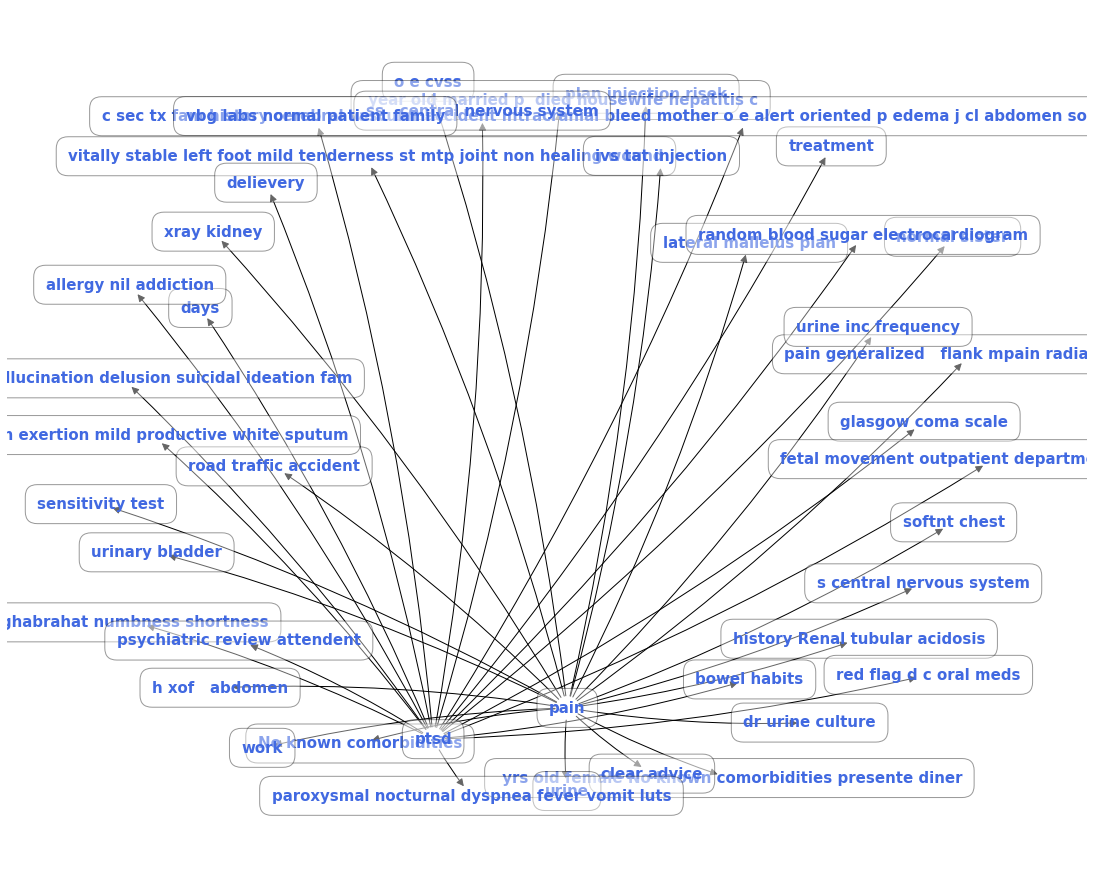

In [64]:
test_df['Links'] = test_df.apply(lambda x: NounChunks(x['HOPI_modified'],x['Ed_dx_modified']),axis=1)

print("Nodes:",len(cmap.nodes))
print("Edges:",len(cmap.edges))
    
pos = nx.spring_layout(cmap, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cmap, pos=pos, connectionstyle='arc3, rad = 0.05', node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cmap.nodes()},arrows=True, arrowsize=15,width=1)
    
plt.axis('off')
plt.show()

In [59]:
def NounChunks(hopi):
    hopi = nlp(hopi)
    chunksHOPI = []
    for nc in hopi.noun_chunks:
        chunksHOPI.append(nc)
    return chunksHOPI 

In [60]:
chunksHopi = test_df['HOPI_modified'].apply(lambda x: NounChunks(x))
chunksEd_dx = test_df['Ed_dx_modified'].apply(lambda y: NounChunks(y))
test_df['HOPI_chunks'] = chunksHopi
test_df['Ed_dx_chunks'] = chunksEd_dx
chunksEd_dx

0                                  [(rti, constipation)]
1      [( , wk, preg), (emergency, room, generalised,...
2                                      [(infected, bed)]
3                                            [(urethra)]
4                                       [(pubic, ramus)]
                             ...                        
191                              [(abdominal, tb, saio)]
192                                                   []
193                                    [(headache, day)]
194                                    [(burns, injury)]
195                                 [(epigestric, pain)]
Name: Ed_dx_modified, Length: 196, dtype: object

In [32]:
test_df = test_df[test_df['HOPI_chunks'].notna()]
test_df = test_df[test_df['Ed_dx_chunks'].notna()]
test_df = test_df[test_df['code'].notna()]
#test_df = test_df.reset_index()
test_df.head()

,level_0,index,mr_code,er_no,age_years,triagecomplaint,hopi_,ed_dx,code,h,HOPI_modified,Ed_dx_modified,Links,HOPI_chunks,Ed_dx_chunks
0,0,0,10190001490,E001400336,32.0019,Unwell adult,32YR OLD M \n\nC/O--FEVER--SINCE YESTERDAY \nV...,RTI/CONSTIPATION,"R50.9, R11.10, R52, M54.9, R05.9, K59.00",32YR OLD M \n\nC/O--FEVER--SINCE YESTERDAY \nV...,yr old m c o fever yesterday vomiting episode ...,rti constipation,None,"[(yr, old, m, c, o, fever), (episode), (watery...","[(rti, constipation)]"
1,1,1,86180009581,E001404472,40.1911,Pregnancy,g6p4+1 ( 2nd marriage) svd\n\ncurrent preg i...,31 wk preg came in er with generalised body w...,"O09.293, Z3A.31, O99.891, R53.1",g6p4+1 ( 2nd marriage) svd\n\ncurrent preg i...,gp nd marriage spontaneous vaginal delivery ...,wk preg came emergency room generalised body ...,None,"[(gp, , nd), (marriage, spontaneous, vaginal...","[( , wk, preg), (emergency, room, generalised,..."
2,2,2,10190005384,E001404582,90.0862,Unwell adult,nkcm \nhx of cva several years \nlft sided wea...,infected bed sore / htn,"I69.398, M62.81, L89.321, L89.150",nkcm \nhx of cva several years \nlft sided wea...,No known comorbidities history cerebral vascul...,infected bed sore hypertension,None,"[(No, known, comorbidities), (liver, function,...","[(infected, bed)]"
3,3,3,10120025208,E001405244,69.5342,Urinary problems,nkcm \nh/o turp - 1 year back \nradical cystec...,bleeding per urethra,"Z85.51, N36.8",nkcm \nh/o turp - 1 year back \nradical cystec...,No known comorbidities h o turp year radical ...,bleeding urethra,None,"[(No, known, comorbidities), (h, o, turp), (ye...",[(urethra)]
4,4,4,10190006313,E001405573,70.0006,Limb problems,"kc of HTN, on oral meds, compliant\n\nhx of fa...",PUBIC RAMUS FRACTURE,"I10, W01.0XXA","kc of HTN, on oral meds, compliant\n\nhx of fa...",known case hypertension oral meds compliant hi...,pubic ramus fracture,None,"[(known, case, hypertension, oral, meds, compl...","[(pubic, ramus)]"
